
# Strategy Based on Simple Moving Averages (SMA) 

In [1]:
import datetime as dt
import numpy as np
import pandas as pd
import pandas_datareader as web
from matplotlib import pyplot as plt
import warnings

plt.style.use('fivethirtyeight')
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
spy = pd.read_csv('SPY.csv')

In [3]:
spy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1762 entries, 0 to 1761
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1762 non-null   object 
 1   High       1762 non-null   float64
 2   Low        1762 non-null   float64
 3   Open       1762 non-null   float64
 4   Close      1762 non-null   float64
 5   Volume     1762 non-null   float64
 6   Adj Close  1762 non-null   float64
dtypes: float64(6), object(1)
memory usage: 96.5+ KB


In [4]:
spy['Date'] = spy['Date'].astype('datetime64')

In [5]:
spy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1762 entries, 0 to 1761
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1762 non-null   datetime64[ns]
 1   High       1762 non-null   float64       
 2   Low        1762 non-null   float64       
 3   Open       1762 non-null   float64       
 4   Close      1762 non-null   float64       
 5   Volume     1762 non-null   float64       
 6   Adj Close  1762 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 96.5 KB


In [6]:
spy = spy.set_index('Date')

In [7]:
spy.head(3)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2013-01-02,146.149994,144.729996,145.110001,146.059998,192059000.0,123.709259
2013-01-03,146.369995,145.339996,145.990005,145.729996,144761800.0,123.429779
2013-01-04,146.610001,145.669998,145.970001,146.369995,116817700.0,123.971779


In [8]:
df_spy = spy[['Close']].rename(columns={'Close':'Price'})

## Calculating the SMAs 
**Using the `.rolling()` method in combination with different calculating operation ie mean, median, std...**

In [9]:
df_spy['SMA1'] = df_spy['Price'].rolling(42).mean()
df_spy['SMA2'] = df_spy['Price'].rolling(252).mean()

In [10]:
df_spy.tail()

,Price,SMA1,SMA2
Date,,,
2019-12-24,321.230011,311.901904,289.817737
2019-12-26,322.940002,312.409999,290.122340
2019-12-27,322.859985,312.875714,290.419126
2019-12-30,321.079987,313.301190,290.710118
2019-12-31,321.859985,313.723094,290.995594


### Visualizing the time series data in combination with the SMAs

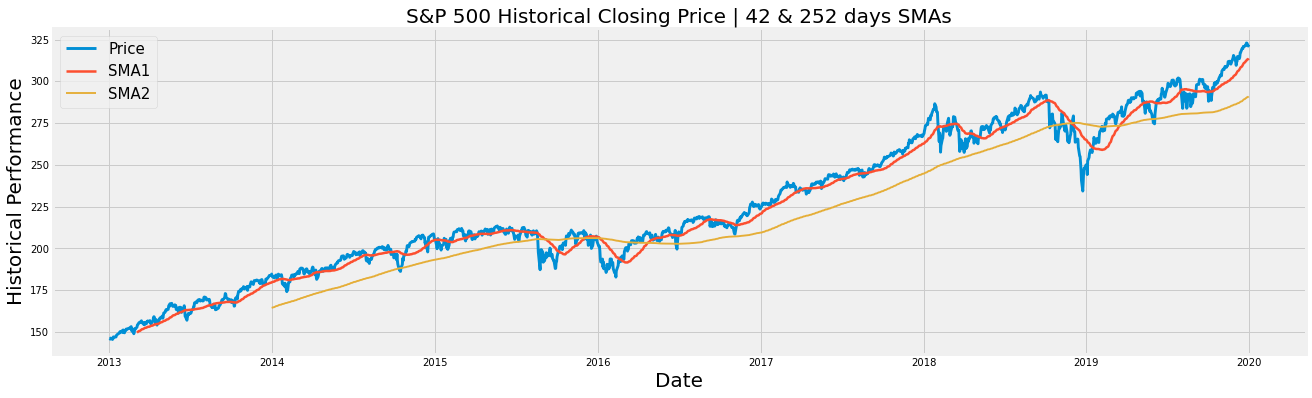

In [11]:
plt.figure(figsize=(20,6))
plt.title('S&P 500 Historical Closing Price | 42 & 252 days SMAs', fontsize=20)
plt.plot(df_spy['Price'], linewidth=2.9, label='Price')
plt.plot(df_spy['SMA1'], linewidth=2.5, label='SMA1')
plt.plot(df_spy['SMA2'], linewidth=1.9, label='SMA2')
plt.xlabel('Date', fontsize=20) 
plt.ylabel('Historical Performance', fontsize=20)
plt.legend(fontsize=15)

Remember the rule is to go long whenever the shorter SMA is above the longer one and vice-versa. This is because you want to short when the prices are high and long when the prices are low. The ideology behind this is that when the prices are high, you want to sell so that you get a profit. And when the prices are low, you want to hold your position (longing) so that when the markets bounces back, you will sell for profit (shorting)

### Visualizing the position over time

In [12]:
df_spy['positon'] = np.where(df_spy['SMA1'] > df_spy['SMA2'], 1, -1)

# np.where produces +1 for rows where the expression is TRUE and -1 for rows where the expression is FALSE

In [13]:
df_spy.dropna(inplace=True)
df_spy.head()

,Price,SMA1,SMA2,positon
Date,,,,
2013-12-31,184.690002,179.734286,164.475357,1
2014-01-02,182.919998,179.904048,164.621627,1
2014-01-03,182.889999,180.063095,164.769087,1
2014-01-06,182.360001,180.194762,164.911905,1
2014-01-07,183.479996,180.366429,165.060754,1


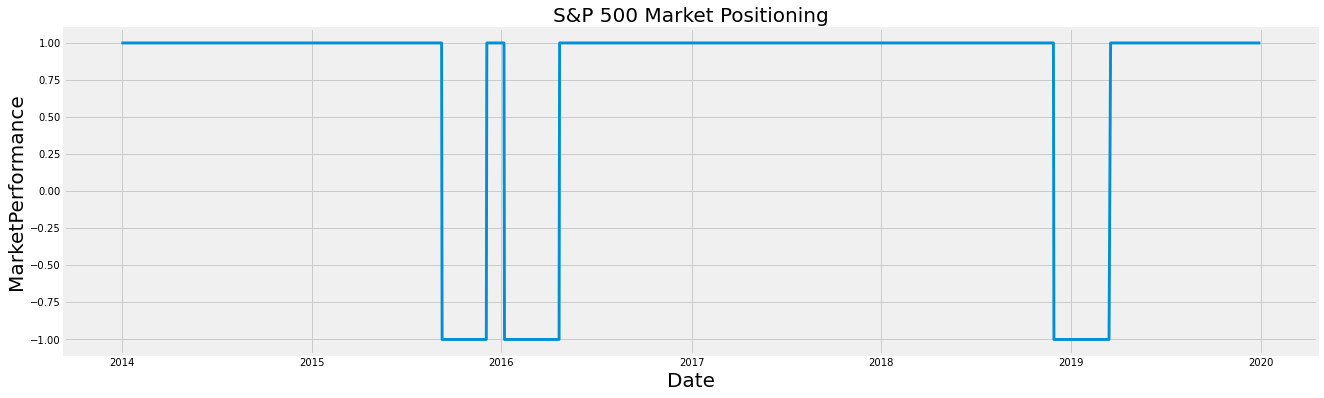

In [14]:
plt.figure(figsize=(20,6))
plt.title('S&P 500 Market Positioning', fontsize=20)
plt.plot(df_spy['positon'], linewidth=2.9)
plt.ylim(-1.1, 1.1)
plt.xlabel('Date', fontsize=20) 
plt.ylabel('MarketPerformance', fontsize=20)
plt.show()

## Calculating the performance of the strategy

To do this, we calculate the log returns based on the original financial time series.

In [15]:
df_spy['Returns'] = np.log(df_spy['Price'] / df_spy['Price'].shift(1))

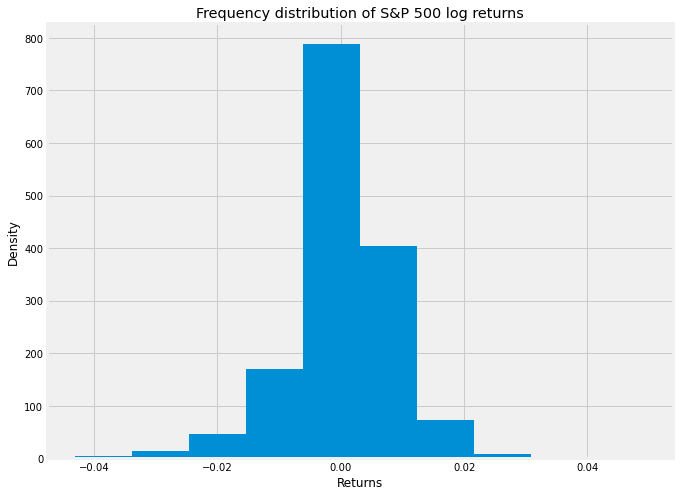

In [16]:
plt.figure(figsize=(10,8))
plt.title('Frequency distribution of S&P 500 log returns')
plt.hist(df_spy['Returns'])
plt.xlabel('Returns')
plt.ylabel('Density')
plt.show()

To derive the strategy returns, multiply the positions column --shifted by one trading day-- with the returns column. Since log returns are additive, calculating the sum over the columns `returns` and `strategy` provides a first comparison of the performance of the strategy relative to the base investment itself.

In [17]:
df_spy['strategy'] = df_spy['positon'].shift(1) * df_spy['Returns']
print('For illustration only;\n')
df_spy[['Returns', 'strategy']].sum()

For illustration only;



Returns     0.555438
strategy    0.200497
dtype: float64

In [18]:
print('For gross performance;\n')
df_spy[['Returns', 'strategy']].sum().apply(np.exp)

For gross performance;



Returns     1.742704
strategy    1.222010
dtype: float64

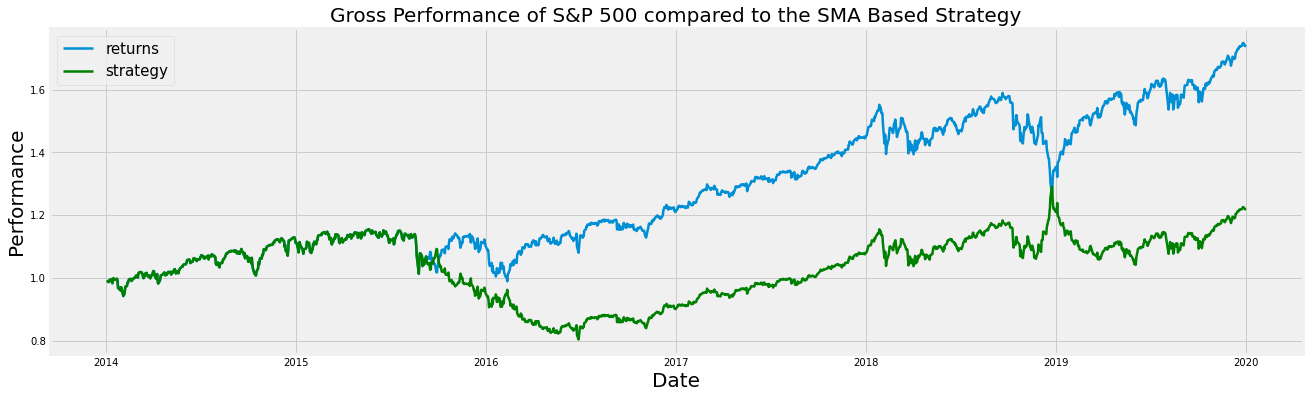

Comparing the returns shows that the passive investment benchmark books a win over Simple Moving Average Based Strategy


In [19]:
plt.figure(figsize=(20,6))
plt.title('Gross Performance of S&P 500 compared to the SMA Based Strategy', fontsize=20)
plt.plot(df_spy['Returns'].cumsum().apply(np.exp), linewidth=2.5, label='returns')
plt.plot(df_spy['strategy'].cumsum().apply(np.exp), linewidth=2.5, label='strategy', color='green')
plt.xlabel('Date', fontsize=20)
plt.ylabel('Performance', fontsize=20)
plt.legend(fontsize=15)
plt.show()
print('Comparing the returns shows that the passive investment benchmark books a win over Simple Moving Average Based Strategy')

### Calculating the average, annualized risk statistics for both the stock and the strategy

In [20]:
df_spy[['Returns', 'strategy']].mean() * 252

Returns     0.092696
strategy    0.033460
dtype: float64

In [21]:
np.exp(df_spy[['Returns', 'strategy']].mean() * 252) -1

Returns     0.097128
strategy    0.034026
dtype: float64

In [22]:
df_spy[['Returns', 'strategy']].std() * 252 ** 0.5

Returns     0.131788
strategy    0.131901
dtype: float64

In [23]:
(df_spy[['Returns', 'strategy']].apply(np.exp)-1).std() * 252 ** 0.5

Returns     0.131560
strategy    0.131595
dtype: float64

### Calculating the Maximum Drawdown and Longest Drawdown periods

In [24]:
df_spy['cumret'] = df_spy['Returns'].cumsum().apply(np.exp) # if strategy performed better, put strategy instead of returns
df_spy['cummax'] = df_spy['cumret'].cummax()

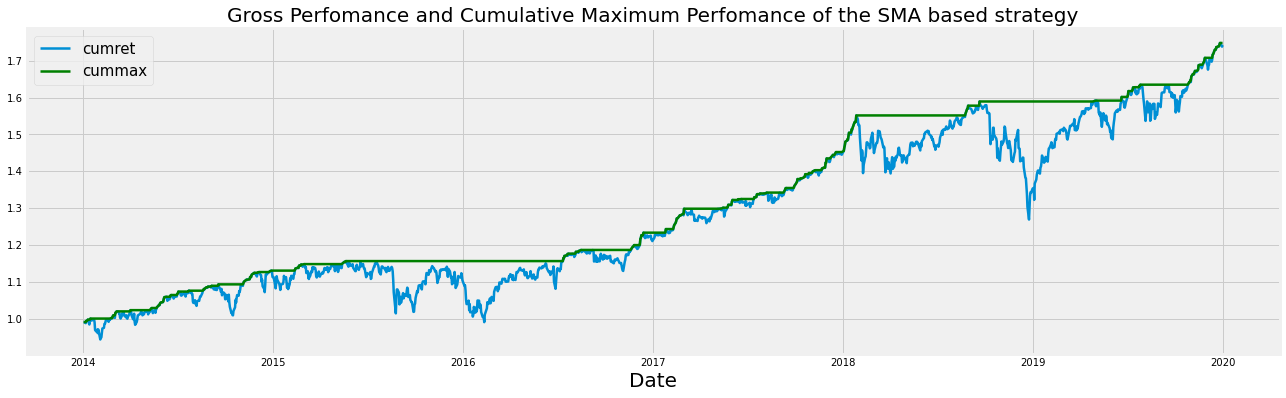

In [25]:
plt.figure(figsize=(20,6))
plt.title('Gross Perfomance and Cumulative Maximum Perfomance of the SMA based strategy', fontsize=20)
plt.plot(df_spy['cumret'], linewidth=2.5, label='cumret')
plt.plot(df_spy['cummax'], linewidth=2.5, label='cummax', color='green')
plt.xlabel('Date', fontsize=20)
plt.legend(fontsize=15)
plt.show()

The maximum drawdown is then calculated as the maximum of the difference between the two relevant column;
        
        cummax - cumret
        
Longest drawdown requires the dates at which the gross performance equals its cummulative maximum i.e where new maximum is set.

**Maximum Drawdown**

In [26]:
drawdown = df_spy['cummax'] - df_spy['cumret']
print(f'The Maximum Drawdown is: {drawdown.max()}')

The Maximum Drawdown is: 0.3207536382656617


**Longest drawdown**

In [27]:
temp = drawdown[drawdown==0]
periods = (temp.index[1:].to_pydatetime() - 
           temp.index[:-1].to_pydatetime())

In [28]:
periods[12:15]

array([datetime.timedelta(days=26), datetime.timedelta(days=40),
       datetime.timedelta(days=1)], dtype=object)

In [29]:
periods.max()

datetime.timedelta(days=418)

In [30]:
print(f'The Maximum drawdown: {drawdown.max()} \nThe Longest drawdown period: {periods.max()}')


The Maximum drawdown: 0.3207536382656617 
The Longest drawdown period: 418 days, 0:00:00


### Conclusions and Remarks

The stock used above is SPY(S&P 500). I would recommend you to tryout different financial instruments i.e bitcoins or currency pairs such as EUR/USD! Using SPY as a stock could be misleading since you may treat it as a single stock while it just tracks the perfomance of Fortune 500 company stocks as a whole. Thus you may look at it as the historical market perfomance.
- From the two SMAs, it looks like we are going to hold a short position of the stock.
- The Gross perfomance of S&P 500 out perfomance the Simple Moving Average Based Strategy since we can see that the stock the passive investment benchmark is better.
- Our stock has a gaussian distribution.
- from the stock we can see that the Maximum drawdown is 0.32 and the Longest drawdown is 418 days. Pretty long huh!